In [ ]:
# default_exp core

# espiownage core

> Core espiownage parts

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export 
import cv2
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [ ]:
#export
def mkdir_if_needed(path):
    try:                # go ahead and try to make the the directory
        os.makedirs(path)
    except FileExistsError: pass
    except OSError as exception:
        if exception.errno != errno.EEXIST:  # ignore error if dir already exists
            raise

In [ ]:
#export 
def meta_to_img_path(meta_file, # filename of .csv file with annotations
    img_bank='images/',         # alternate location of image files, if not in same dir as meta file
    ):
    '''Suggest the image file that corresponds with an annotation CSV file'''
    meta_file, img_dir = Path(meta_file), Path(os.path.expanduser(img_bank))
    img_file = meta_file.with_suffix('.png')  # check same directory as meta first
    if os.path.exists(img_file): return img_file
    return img_dir / Path(img_file.name)  # return from image storage directory

In [ ]:
meta_to_img_path('annotations/06241902_proc_00023.csv')

PosixPath('images/06241902_proc_00023.png')

In [ ]:
#export 
def meta_to_mask_path(
    meta_file, # filename of .csv file with annotations
    mask_dir='masks/',  # output directory; assumed to exist
    ):
    "provides name for segmentation mask file"
    csv_path = Path(meta_file)
    return Path(mask_dir + csv_path.stem+'_P.png')  # _P because that's what CAMVID dataset does  

In [ ]:
meta_to_mask_path('annotations/06241902_proc_00023.csv')

PosixPath('masks/06241902_proc_00023_P.png')

In [ ]:
#export 
def fix_abangle(a,b,angle):
    "Makes sure semimajor axis > semiminor axis, and angles are consistent"
    if b > a:
        a, b, angle = b, a, angle+90
    if angle < 0: angle += 180
    elif angle >= 180: angle -= 180
    return a, b, angle

In [ ]:
fix_abangle(5,10,-20)

(10, 5, 70)

In [ ]:
#export 
def draw_ellipse(
    img,     # a cv2 image, not a PIL image?
    center, axes, angle,
    startAngle=0, endAngle=360, color=(0) ,
    thickness=2, lineType=cv2.LINE_AA, shift=10, filled=False):
    """"Draws an ellipse into image.
    startAngle & endAngle should are arc-angles. They should stay at 0 & 360 for full ellipses.
    """
    center = [int(round(x* 2**shift)) for x in center]  
    axes = [int(round(x* 2**shift)) for x in axes]
    if filled: lineType,thickness = cv2.FILLED, -1
    ellipse = cv2.ellipse(
        img, center, axes, -angle,   # -angle because the web interface is "upside down"
        startAngle, endAngle, color,
        thickness, lineType, shift)
    return ellipse

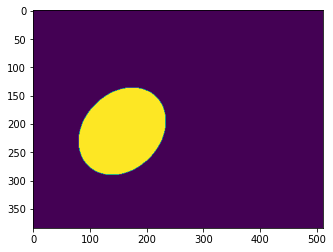

In [ ]:
height, width = 512,384
img = np.zeros((width, height), dtype=np.uint8)  # numpy w/h is "backwards" to images
cx, cy, a, b, angle = 157, 213, 85, 67, 45
img = draw_ellipse(img, (cx,cy), (a,b), angle, color=100, filled=True)
plt.imshow(img)

In [ ]:
#export 
def ellipse_to_bbox(x, y, a, b, angle_deg,
    clip=True, width=512, height=384):  # cx, cy, a, b, angle
    "Get bounding box of ellipse, cf. https://gist.github.com/smidm/b398312a13f60c24449a2c7533877dc0"
    major, minor = 2*a, 2*b 
    t = np.arctan(-minor / 2 * np.tan(np.radians(angle_deg)) / (major / 2))
    [max_x, min_x] = sorted([x + major / 2 * np.cos(t) * np.cos(np.radians(angle_deg)) -
                      minor / 2 * np.sin(t) * np.sin(np.radians(angle_deg)) for t in (t, t + np.pi)],reverse=True)
    t = np.arctan(minor / 2 * 1. / np.tan(np.radians(angle_deg)) / (major / 2))
    [max_y, min_y] = sorted([y + minor / 2 * np.sin(t) * np.cos(np.radians(angle_deg)) +
                      major / 2 * np.cos(t) * np.sin(np.radians(angle_deg)) for t in (t, t + np.pi)],reverse=True)
    if clip:
      min_x = np.clip(min_x, 0, width)
      max_x = np.clip(max_x, 0, width)
      min_y = np.clip(min_y, 0, height)
      max_y = np.clip(max_y, 0, height)
    return int(min_x), int(min_y), int(max_x), int(max_y)

(80, 136, 233, 289)


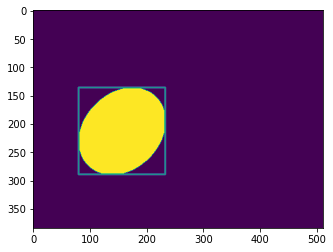

In [ ]:
bb = ellipse_to_bbox(cx, cy, a, b, angle)
print(bb)
img = cv2.rectangle(img, bb[0:2], bb[2:4], color=50, thickness=2)
plt.imshow(img)